# 投球タイプ分類器（Pitch Identification Model）

本プロジェクトは、pybaseballライブラリを用いてMLBのStatcastデータを取得し、投球の物理的な特徴量（球速、回転、変化量など）からその球種（pitch_type）を分類する機械学習モデルを構築します。


## 目次
0. ライブラリ・データ読み込み
1. データの概観・分析・前処理
2. ベースラインモデルの構築
3. 特徴量エンジニアリング
4. 様々なモデルの構築・調整
5. モデルのアンサンブリング
6. 予測の出力・評価


## 0. ライブラリ・データ読み込み

まず初めに使用するライブラリを読み込みます。


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データ取得ライブラリ
from pybaseball import statcast

# 機械学習モデル
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# 警告非表示
import warnings
warnings.filterwarnings('ignore')


次にpybaseball.statcast()を用いて、特定の期間の投球データを取得します。

注意：全期間を取得するとデータ量が膨大になるため、期間を絞るか、特定の投手でテストすることを推奨します。


In [6]:
# 例：2023年シーズンのデータを取得
# (注意：全期間を取得するとデータ量が膨大になるため、期間を絞るか、特定の投手でテストする)
print("Fetching Statcast data...")
data = statcast(start_dt='2023-04-01', end_dt='2023-10-01')
print("Data fetched.")
print(f"Data shape: {data.shape}")


Fetching Statcast data...
This is a large query, it may take a moment to complete


100%|██████████| 184/184 [01:12<00:00,  2.55it/s]


Data fetched.
Data shape: (714703, 118)


## 1. データの概観・分析・前処理

### 1.1 データの概観

データのサイズを確認します。


In [7]:
print(f'データ数は{data.shape[0]}、変数は{data.shape[1]}種類です。')


データ数は714703、変数は118種類です。


In [8]:
# データの最初の数行を確認
data.head(10)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2439,CH,2023-10-01,89.0,-2.8,5.59,"Robertson, Nick",677008,687798,field_out,hit_into_play,...,<NA>,2.55,1.53,-1.53,31.7,1.676715,-1.896554,41.830979,30.714944,26.41202
2491,FF,2023-10-01,96.9,-2.4,5.9,"Robertson, Nick",677008,687798,NaN,foul,...,<NA>,1.09,0.76,-0.76,47.4,8.715532,3.692542,40.551342,33.656454,26.020583
2596,CH,2023-10-01,90.0,-2.93,5.56,"Robertson, Nick",677008,687798,NaN,ball,...,<NA>,2.47,1.65,-1.65,30.3,<NA>,<NA>,<NA>,<NA>,<NA>
2682,ST,2023-10-01,82.2,-3.09,5.55,"Robertson, Nick",677008,687798,NaN,ball,...,<NA>,3.14,-1.43,1.43,28.9,<NA>,<NA>,<NA>,<NA>,<NA>
2790,CH,2023-10-01,89.2,-2.87,5.58,"Robertson, Nick",677008,687798,NaN,swinging_strike,...,<NA>,2.57,1.49,-1.49,34.3,20.169759,-7.584644,37.675911,44.236969,36.187039
2914,FF,2023-10-01,96.2,-2.37,5.96,"Robertson, Nick",677008,687798,NaN,swinging_strike,...,<NA>,1.08,0.71,-0.71,43.8,14.642472,4.79365,37.058134,27.45065,20.292713
2994,CH,2023-10-01,88.2,-2.86,5.51,"Robertson, Nick",602104,687798,strikeout,swinging_strike,...,6,2.51,1.45,1.45,31.8,12.675671,-25.318306,32.984103,29.051912,38.369551
3155,FF,2023-10-01,95.7,-2.4,5.8,"Robertson, Nick",602104,687798,NaN,foul,...,6,1.19,0.48,0.48,38.4,-3.690621,14.173457,27.01586,46.463475,19.285215
3285,ST,2023-10-01,79.4,-2.96,5.67,"Robertson, Nick",602104,687798,NaN,ball,...,6,3.82,-1.66,-1.66,32.4,<NA>,<NA>,<NA>,<NA>,<NA>
3415,ST,2023-10-01,82.9,-2.82,5.66,"Robertson, Nick",602104,687798,NaN,ball,...,6,3.29,-1.16,-1.16,32.8,<NA>,<NA>,<NA>,<NA>,<NA>


In [10]:
# 変数名の一覧を確認
data.columns.tolist()


['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'fielder_2',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimated_woba_using_speedangle',
 'w

### 1.2 データの分析（EDA）

探索的データ分析（EDA）を行います。まず、必要な特徴量とターゲットが存在することを確認します。


In [11]:
# 必要な特徴量の確認
required_features = ['release_speed', 'release_spin_rate', 'spin_axis', 
                     'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'pitch_type']

# 存在する特徴量を確認
available_features = [feat for feat in required_features if feat in data.columns]
missing_features = [feat for feat in required_features if feat not in data.columns]

print("利用可能な特徴量:", available_features)
print("欠損している特徴量:", missing_features)

# 利用可能な特徴量のみを使用
if len(missing_features) > 0:
    print(f"\n警告: 以下の特徴量がデータに存在しません: {missing_features}")
    print("利用可能な特徴量のみを使用します。")


利用可能な特徴量: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'pitch_type']
欠損している特徴量: []


In [12]:
# 欠損値の確認（利用可能な特徴量のみ）
print("欠損値の確認:")
if len(available_features) > 0:
    print(data[available_features].isnull().sum())
else:
    print("利用可能な特徴量がありません。")


欠損値の確認:
release_speed        2820
release_spin_rate    6779
spin_axis            6777
pfx_x                2822
pfx_z                2822
release_pos_x        2822
release_pos_z        2822
pitch_type           2983
dtype: int64


In [13]:
# ターゲット（pitch_type）の分析
if 'pitch_type' in data.columns:
    print("球種の内訳:")
    print(data['pitch_type'].value_counts())
    print("\n球種の割合:")
    print(data['pitch_type'].value_counts(normalize=True))
else:
    print("エラー: 'pitch_type'列がデータに存在しません。")


球種の内訳:
pitch_type
FF    228328
SL    114396
SI    110269
CH     77250
FC     56262
CU     47154
ST     41688
FS     15955
KC     14744
SV      2842
FA      1114
FO       778
EP       558
KN       192
SC        74
CS        70
PO        46
Name: count, dtype: int64

球種の割合:
pitch_type
FF    0.320812
SL    0.160732
SI    0.154933
CH    0.108540
FC    0.079051
CU    0.066254
ST    0.058574
FS    0.022418
KC    0.020716
SV    0.003993
FA    0.001565
FO    0.001093
EP    0.000784
KN    0.000270
SC    0.000104
CS    0.000098
PO    0.000065
Name: proportion, dtype: float64


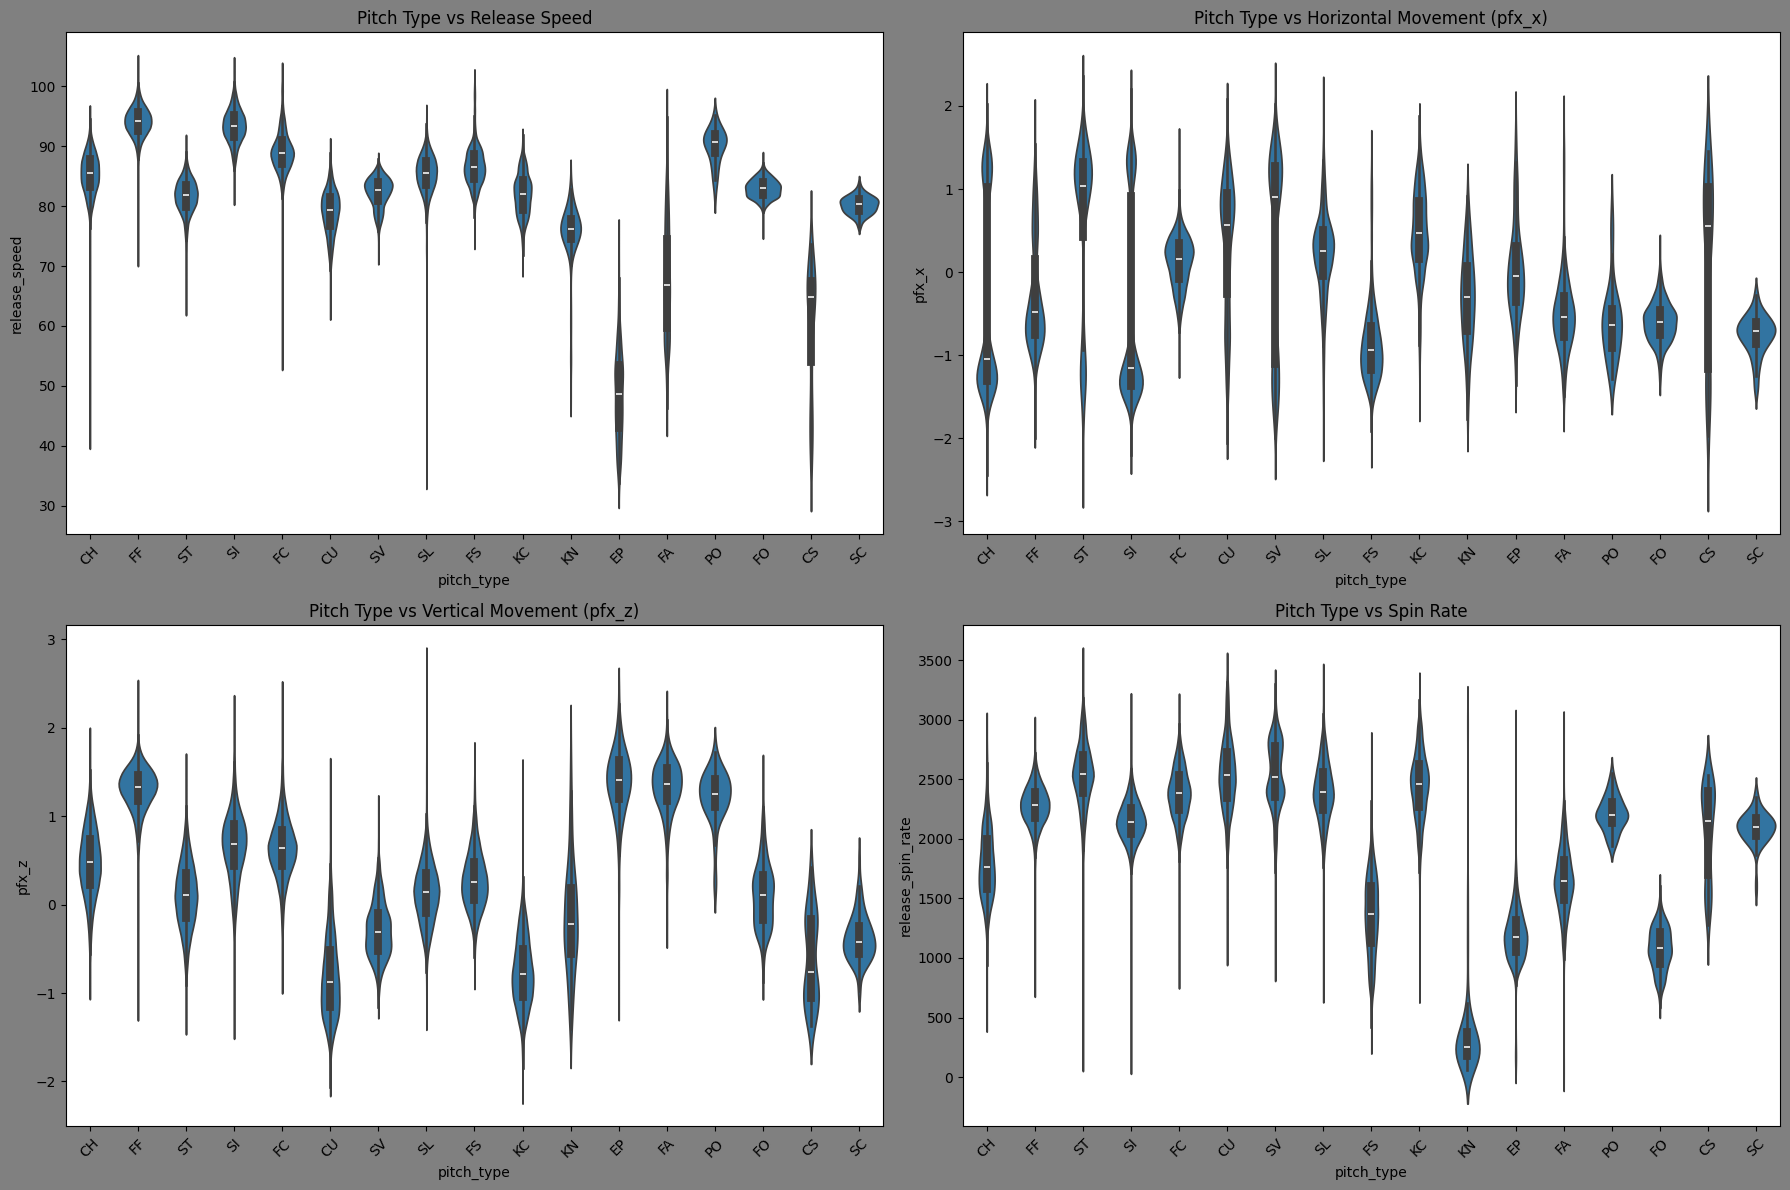

In [14]:
# 球種ごとの分布を可視化（バイオリン図）
# 利用可能な特徴量のみを使用
plot_features = []
if 'release_speed' in data.columns:
    plot_features.append(('release_speed', 'Release Speed'))
if 'pfx_x' in data.columns:
    plot_features.append(('pfx_x', 'Horizontal Movement (pfx_x)'))
if 'pfx_z' in data.columns:
    plot_features.append(('pfx_z', 'Vertical Movement (pfx_z)'))
if 'release_spin_rate' in data.columns:
    plot_features.append(('release_spin_rate', 'Spin Rate'))

if len(plot_features) > 0 and 'pitch_type' in data.columns:
    # データのコピーを作成してインデックスをリセット（重複インデックスの問題を回避）
    plot_data = data[['pitch_type'] + [feat for feat, _ in plot_features]].copy().reset_index(drop=True)
    
    n_plots = min(len(plot_features), 4)
    n_cols = 2
    n_rows = (n_plots + 1) // 2
    f, ax = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows), facecolor='gray')
    if n_rows == 1:
        ax = ax.reshape(1, -1)
    
    for idx, (feat, title) in enumerate(plot_features[:4]):
        row = idx // n_cols
        col = idx % n_cols
        sns.violinplot(x="pitch_type", y=feat, data=plot_data, ax=ax[row, col])
        ax[row, col].set_title(f'Pitch Type vs {title}')
        ax[row, col].tick_params(axis='x', rotation=45)
    
    # 余ったサブプロットを非表示
    for idx in range(n_plots, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("可視化に必要な特徴量が不足しています。")


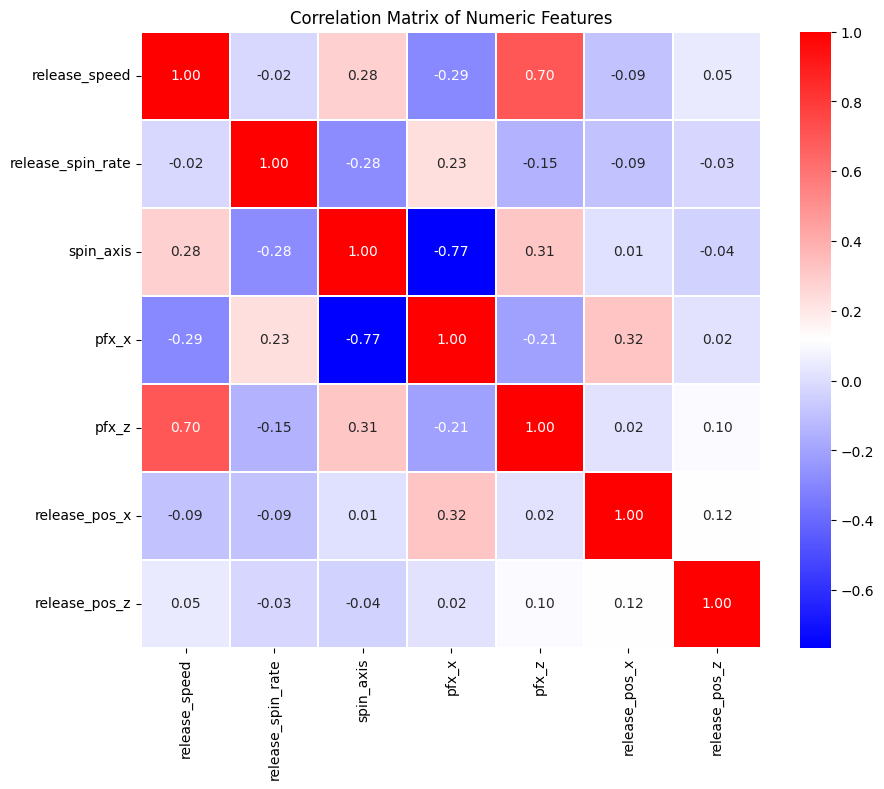

In [12]:
# 相関行列のヒートマップ
numeric_features = ['release_speed', 'release_spin_rate', 'spin_axis', 
                    'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z']
# 存在する特徴量のみを使用
numeric_features_available = [feat for feat in numeric_features if feat in data.columns]

if len(numeric_features_available) > 0:
    df_numeric = data[numeric_features_available].select_dtypes(include=['number'])
    if len(df_numeric.columns) > 0:
        sns.heatmap(df_numeric.corr(), annot=True, cmap='bwr', linewidths=0.2, fmt='.2f')
        fig = plt.gcf()
        fig.set_size_inches(10, 8)
        plt.title('Correlation Matrix of Numeric Features')
        plt.show()
    else:
        print("数値型の特徴量がありません。")
else:
    print("相関行列を作成するための特徴量が不足しています。")


### 1.3 データの前処理

機械学習モデルが学習できるようにデータの前処理を行います。


In [13]:
# データのコピーを作成
df = data.copy()

# 必要な特徴量を選択（存在する特徴量のみ）
feature_cols = ['release_speed', 'release_spin_rate', 'spin_axis', 
                'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z']
feature_cols = [feat for feat in feature_cols if feat in df.columns]

if len(feature_cols) == 0:
    raise ValueError("必要な特徴量がデータに存在しません。")

print(f"使用する特徴量: {feature_cols}")

# 欠損値の処理：欠損が多い行を削除
print("前処理前のデータ数:", len(df))
if 'pitch_type' in df.columns:
    df = df.dropna(subset=feature_cols + ['pitch_type'])
else:
    raise ValueError("'pitch_type'列がデータに存在しません。")
print("前処理後のデータ数:", len(df))

# 欠損値の確認
print("\n欠損値の確認:")
print(df[feature_cols + ['pitch_type']].isnull().sum())


使用する特徴量: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z']
前処理前のデータ数: 714703
前処理後のデータ数: 707792

欠損値の確認:
release_speed        0
release_spin_rate    0
spin_axis            0
pfx_x                0
pfx_z                0
release_pos_x        0
release_pos_z        0
pitch_type           0
dtype: int64


In [14]:
# 投球数が少ない球種を除外または「Others」にまとめる
pitch_counts = df['pitch_type'].value_counts()
print("各球種の投球数:")
print(pitch_counts)

# 投球数が100未満の球種を「Others」にまとめる（閾値は調整可能）
min_pitches = 100
rare_pitches = pitch_counts[pitch_counts < min_pitches].index.tolist()
print(f"\n投球数が{min_pitches}未満の球種（Othersにまとめる）: {rare_pitches}")

if len(rare_pitches) > 0:
    df['pitch_type'] = df['pitch_type'].replace(rare_pitches, 'Others')
    print("\n処理後の球種の内訳:")
    print(df['pitch_type'].value_counts())


各球種の投球数:
pitch_type
FF    227319
SL    113741
SI    109410
CH     76883
FC     55985
CU     46914
ST     41351
FS     15864
KC     14699
SV      2810
FA      1113
FO       766
EP       557
KN       192
SC        74
CS        68
PO        46
Name: count, dtype: int64

投球数が100未満の球種（Othersにまとめる）: ['SC', 'CS', 'PO']

処理後の球種の内訳:
pitch_type
FF        227319
SL        113741
SI        109410
CH         76883
FC         55985
CU         46914
ST         41351
FS         15864
KC         14699
SV          2810
FA          1113
FO           766
EP           557
KN           192
Others       188
Name: count, dtype: int64


In [15]:
# 特徴量（X）とターゲット（Y）を抽出
X = df[feature_cols].values
y = df['pitch_type'].values

# ターゲットのエンコーディング（LabelEncoder）
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("特徴量の形状:", X.shape)
print("ターゲットの形状:", y_encoded.shape)
print("球種のクラス数:", len(le.classes_))
print("球種のクラス:", le.classes_)


特徴量の形状: (707792, 7)
ターゲットの形状: (707792,)
球種のクラス数: 15
球種のクラス: ['CH' 'CU' 'EP' 'FA' 'FC' 'FF' 'FO' 'FS' 'KC' 'KN' 'Others' 'SI' 'SL' 'ST'
 'SV']


In [16]:
# データの分割（訓練データと検証データ）
X_train, X_valid, y_train, y_valid = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print(f"訓練データ数: {X_train.shape[0]}")
print(f"検証データ数: {X_valid.shape[0]}")


訓練データ数: 495454
検証データ数: 212338


## 2. ベースラインモデルの構築

まずは単純なモデルで、現状のデータと前処理でどの程度の精度が出るかを確認します。


In [17]:
# ベースラインモデル：全特徴量を使用
rfc_baseline = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_baseline.fit(X_train, y_train)

print('ベースラインモデル（全特徴量）')
print('Train Score: {}'.format(round(rfc_baseline.score(X_train, y_train), 3)))
print('Valid Score: {}'.format(round(rfc_baseline.score(X_valid, y_valid), 3)))


ベースラインモデル（全特徴量）
Train Score: 0.849
Valid Score: 0.845


## 3. 特徴量エンジニアリング

ドメイン知識（野球の知識）に基づき、よりモデルの精度向上に寄与する特徴量を作成します。


In [18]:
# 特徴量エンジニアリング用のデータフレームを作成
df_fe = df.copy()

# 1. 回転軸の変換（spin_axisは循環的な特徴量なので、sinとcosに変換）
if 'spin_axis' in df_fe.columns:
    df_fe['spin_axis_sin'] = np.sin(np.radians(df_fe['spin_axis']))
    df_fe['spin_axis_cos'] = np.cos(np.radians(df_fe['spin_axis']))
    print("spin_axis_sin と spin_axis_cos を作成しました。")
else:
    print("警告: 'spin_axis'が存在しないため、spin_axis_sin と spin_axis_cos をスキップします。")

# 2. 変化量の合成（水平変化量と垂直変化量から総変化量を計算）
if 'pfx_x' in df_fe.columns and 'pfx_z' in df_fe.columns:
    df_fe['total_movement'] = np.sqrt(df_fe['pfx_x']**2 + df_fe['pfx_z']**2)
    print("total_movement を作成しました。")
else:
    print("警告: 'pfx_x' または 'pfx_z' が存在しないため、total_movement をスキップします。")

# 3. スピン効率（推定）：球速に対する回転数の比率
if 'release_spin_rate' in df_fe.columns and 'release_speed' in df_fe.columns:
    # ゼロ除算を防ぐため、release_speedが0の場合はNaNにする
    df_fe['spin_per_mph'] = df_fe['release_spin_rate'] / df_fe['release_speed'].replace(0, np.nan)
    print("spin_per_mph を作成しました。")
else:
    print("警告: 'release_spin_rate' または 'release_speed' が存在しないため、spin_per_mph をスキップします。")

# 新しい特徴量を確認
new_feature_list = []
if 'spin_axis_sin' in df_fe.columns:
    new_feature_list.append('spin_axis_sin')
if 'spin_axis_cos' in df_fe.columns:
    new_feature_list.append('spin_axis_cos')
if 'total_movement' in df_fe.columns:
    new_feature_list.append('total_movement')
if 'spin_per_mph' in df_fe.columns:
    new_feature_list.append('spin_per_mph')

if len(new_feature_list) > 0:
    print("\n新しく作成した特徴量:")
    print(df_fe[new_feature_list].head())
    print("\n欠損値の確認:")
    print(df_fe[new_feature_list].isnull().sum())
else:
    print("\n新しく作成された特徴量はありません。")


spin_axis_sin と spin_axis_cos を作成しました。
total_movement を作成しました。
spin_per_mph を作成しました。

新しく作成した特徴量:
      spin_axis_sin  spin_axis_cos  total_movement  spin_per_mph
2442      -0.939693       -0.34202        1.565184     19.134831
2531      -0.515038      -0.857167        1.557947     22.218782
2630      -0.939693       -0.34202        1.688816     18.866667
2723       0.848048       0.529919        1.457155     33.892944
2838       -0.97437      -0.224951        1.521907     17.813901

欠損値の確認:
spin_axis_sin     0
spin_axis_cos     0
total_movement    0
spin_per_mph      0
dtype: int64


In [19]:
# 特徴量エンジニアリング後の特徴量リスト
new_features = ['spin_axis_sin', 'spin_axis_cos', 'total_movement', 'spin_per_mph']
feature_cols_fe = feature_cols + [feat for feat in new_features if feat in df_fe.columns]

# 欠損値の処理
df_fe = df_fe.dropna(subset=feature_cols_fe + ['pitch_type'])

# 特徴量とターゲットを抽出
X_fe = df_fe[feature_cols_fe].values
y_fe = df_fe['pitch_type'].values

# ターゲットのエンコーディング（新しいLabelEncoderを作成してfit_transformを使用）
# 特徴量エンジニアリング後のデータでも同じ球種が含まれているはずですが、
# 念のため新しいLabelEncoderを使用します
le_fe = LabelEncoder()
y_fe_encoded = le_fe.fit_transform(y_fe)

# データの分割
# stratifyを使用するため、インデックスではなく配列を直接分割
X_fe_train, X_fe_valid, y_fe_train, y_fe_valid = train_test_split(
    X_fe, y_fe_encoded, test_size=0.3, random_state=42, stratify=y_fe_encoded
)

print(f"特徴量エンジニアリング後の特徴量数: {len(feature_cols_fe)}")
print(f"特徴量: {feature_cols_fe}")
print(f"訓練データ数: {X_fe_train.shape[0]}")
print(f"検証データ数: {X_fe_valid.shape[0]}")
print(f"球種のクラス数: {len(le_fe.classes_)}")
print(f"球種のクラス: {le_fe.classes_}")


特徴量エンジニアリング後の特徴量数: 11
特徴量: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'spin_axis_sin', 'spin_axis_cos', 'total_movement', 'spin_per_mph']
訓練データ数: 495454
検証データ数: 212338
球種のクラス数: 15
球種のクラス: ['CH' 'CU' 'EP' 'FA' 'FC' 'FF' 'FO' 'FS' 'KC' 'KN' 'Others' 'SI' 'SL' 'ST'
 'SV']


In [20]:
# 特徴量エンジニアリング後のベースラインモデル
rfc_fe = RandomForestClassifier(max_depth=7, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_fe.fit(X_fe_train, y_fe_train)

print('特徴量エンジニアリング後のベースラインモデル')
print('Train Score: {}'.format(round(rfc_fe.score(X_fe_train, y_fe_train), 3)))
print('Valid Score: {}'.format(round(rfc_fe.score(X_fe_valid, y_fe_valid), 3)))


特徴量エンジニアリング後のベースラインモデル
Train Score: 0.811
Valid Score: 0.811


## 4. 様々なモデルの構築・調整

ベースラインモデルや特徴量エンジニアリングの結果を踏まえ、より強力なモデルを構築・調整します。


In [21]:
# XGBoostモデル
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_fe_train, y_fe_train)

print('XGBoostモデル')
print('Train Score: {}'.format(round(xgb_model.score(X_fe_train, y_fe_train), 3)))
print('Valid Score: {}'.format(round(xgb_model.score(X_fe_valid, y_fe_valid), 3)))
print('Valid F1 Score (weighted): {}'.format(round(f1_score(y_fe_valid, xgb_model.predict(X_fe_valid), average='weighted'), 3)))


XGBoostモデル
Train Score: 0.887
Valid Score: 0.881
Valid F1 Score (weighted): 0.88


In [22]:
# LightGBMモデル
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_fe_train, y_fe_train)

print('LightGBMモデル')
print('Train Score: {}'.format(round(lgb_model.score(X_fe_train, y_fe_train), 3)))
print('Valid Score: {}'.format(round(lgb_model.score(X_fe_valid, y_fe_valid), 3)))
print('Valid F1 Score (weighted): {}'.format(round(f1_score(y_fe_valid, lgb_model.predict(X_fe_valid), average='weighted'), 3)))


LightGBMモデル
Train Score: 0.737
Valid Score: 0.733
Valid F1 Score (weighted): 0.735


In [23]:
# ハイパーパラメータチューニング（GridSearchCV）- LightGBMの例
# 注意：計算時間がかかるため、パラメータの範囲を狭めています
param_grid_lgb = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

print("GridSearchCVを実行中...（時間がかかる場合があります）")
lgb_gs = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    param_grid_lgb,
    cv=3,  # クロスバリデーションの分割数（計算時間を考慮して3に設定）
    scoring='accuracy',
    n_jobs=-1
)
lgb_gs.fit(X_fe_train, y_fe_train)

print('Best Parameters: {}'.format(lgb_gs.best_params_))
print('CV Score: {}'.format(round(lgb_gs.best_score_, 3)))
print('Valid Score: {}'.format(round(lgb_gs.score(X_fe_valid, y_fe_valid), 3)))


GridSearchCVを実行中...（時間がかかる場合があります）
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
CV Score: 0.876
Valid Score: 0.879


## 5. モデルのアンサンブリング

複数のモデルを組み合わせて、より頑健なモデルとします。


In [24]:
# 各モデルの予測確率を取得
rfc_pred_proba = rfc_fe.predict_proba(X_fe_valid)
xgb_pred_proba = xgb_model.predict_proba(X_fe_valid)
lgb_pred_proba = lgb_model.predict_proba(X_fe_valid)

# 予測確率の平均（ブレンディング）
ensemble_pred_proba = (rfc_pred_proba + xgb_pred_proba + lgb_pred_proba) / 3
ensemble_pred = ensemble_pred_proba.argmax(axis=1)

# アンサンブルモデルの評価
ensemble_accuracy = accuracy_score(y_fe_valid, ensemble_pred)
ensemble_f1 = f1_score(y_fe_valid, ensemble_pred, average='weighted')

print('アンサンブルモデル（RandomForest + XGBoost + LightGBM）')
print('Valid Accuracy: {}'.format(round(ensemble_accuracy, 3)))
print('Valid F1 Score (weighted): {}'.format(round(ensemble_f1, 3)))


アンサンブルモデル（RandomForest + XGBoost + LightGBM）
Valid Accuracy: 0.829
Valid F1 Score (weighted): 0.826


## 6. 予測の出力・評価

最終的に構築したモデルを使い、検証データに対して予測を行い、詳細な評価を行います。


In [25]:
# 最良モデル（アンサンブルモデル）の予測
best_pred = ensemble_pred

# Classification Report（適合率、再現率、F1スコア）
# 特徴量エンジニアリング後のLabelEncoderを使用
print("Classification Report:")
print(classification_report(y_fe_valid, best_pred, target_names=le_fe.classes_))


Classification Report:
              precision    recall  f1-score   support

          CH       0.85      0.90      0.87     23065
          CU       0.79      0.76      0.78     14074
          EP       0.88      0.66      0.75       167
          FA       0.79      0.69      0.73       334
          FC       0.67      0.57      0.62     16796
          FF       0.92      0.95      0.93     68196
          FO       0.89      0.29      0.44       230
          FS       0.76      0.56      0.65      4759
          KC       0.67      0.45      0.54      4410
          KN       0.93      0.64      0.76        58
      Others       0.06      0.07      0.06        56
          SI       0.89      0.86      0.88     32823
          SL       0.73      0.80      0.76     34122
          ST       0.72      0.76      0.74     12405
          SV       0.65      0.32      0.43       843

    accuracy                           0.83    212338
   macro avg       0.75      0.62      0.66    212338
wei

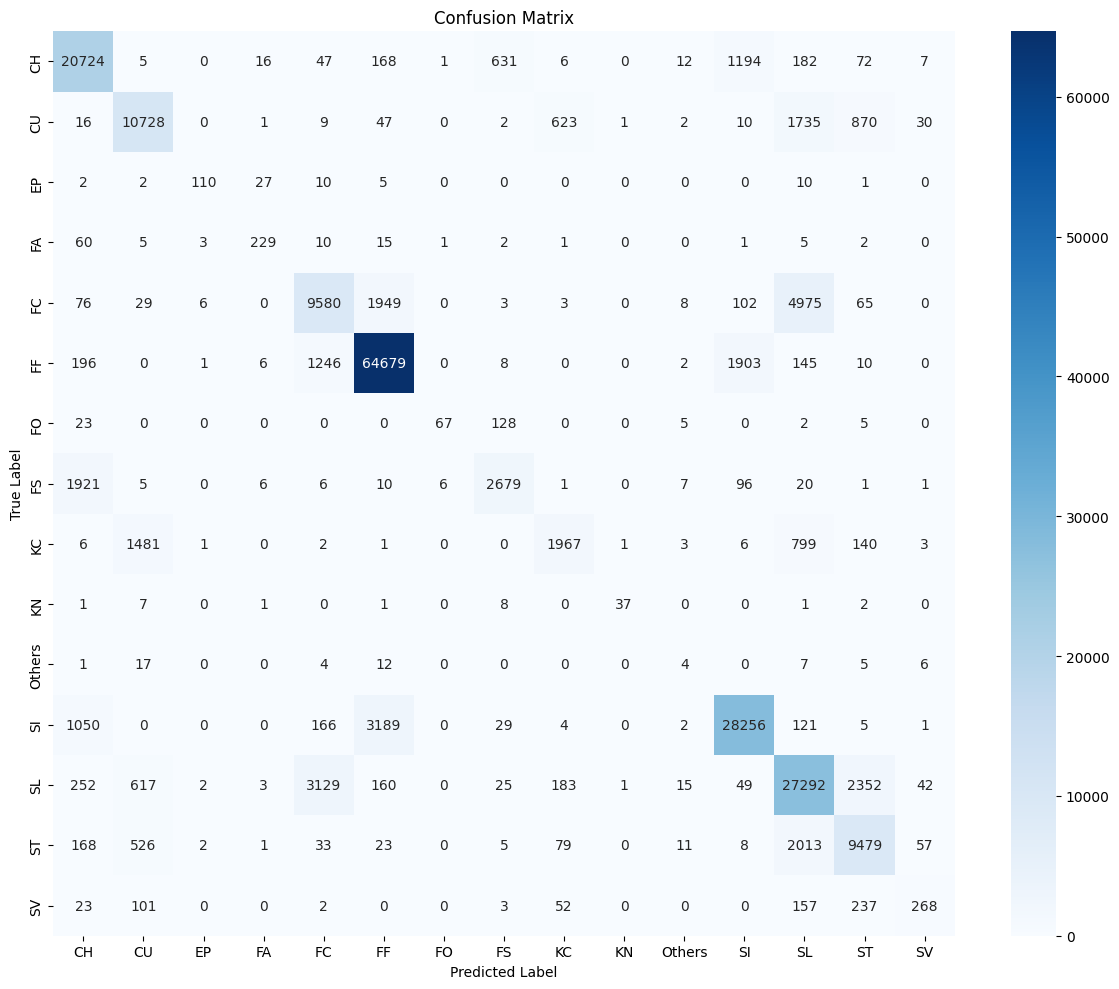

In [26]:
# 混同行列（Confusion Matrix）
cm = confusion_matrix(y_fe_valid, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_fe.classes_, yticklabels=le_fe.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


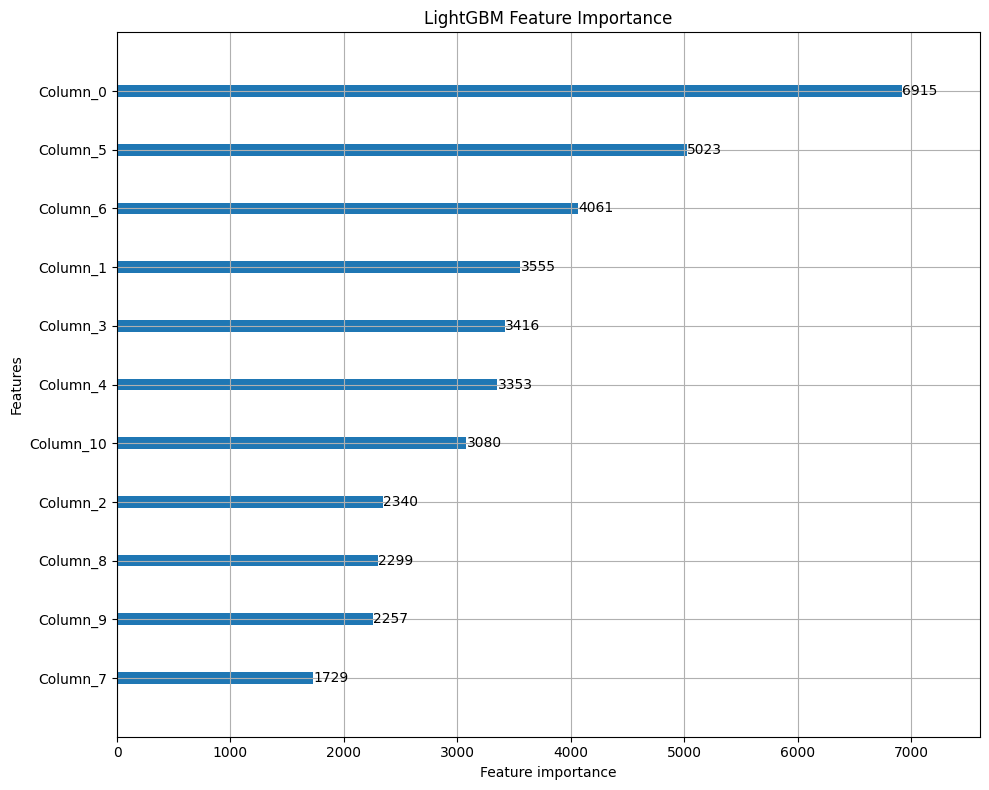

In [31]:
# Feature Importance（特徴量重要度）の可視化 - LightGBM
lgb.plot_importance(lgb_model, figsize=(10, 8), max_num_features=15)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

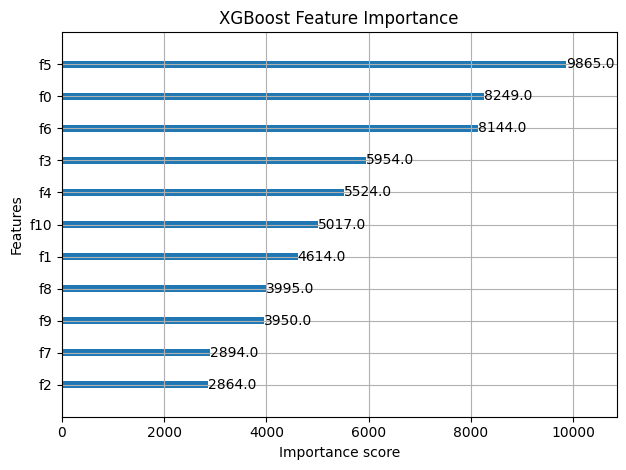

In [36]:
# Feature Importance（特徴量重要度）の可視化 - XGBoost
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


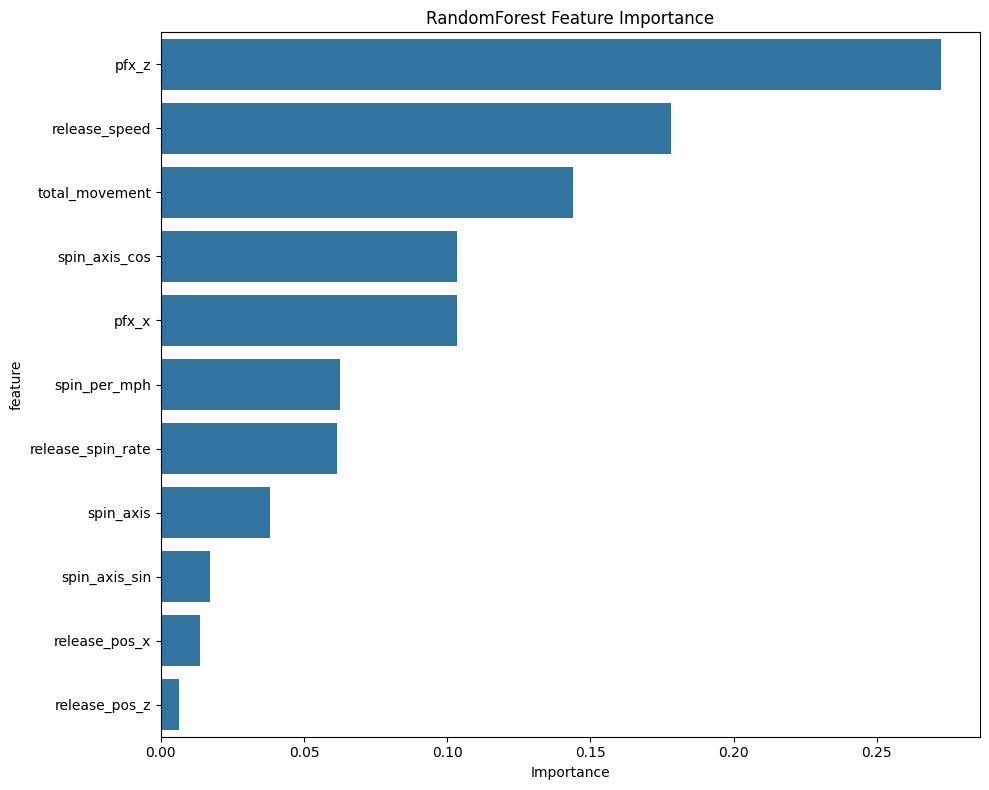

In [33]:
# RandomForestの特徴量重要度
feature_importance = pd.DataFrame({
    'feature': feature_cols_fe,
    'importance': rfc_fe.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('RandomForest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
